HBox(children=(ToggleButtons(description='Type performance', options=('Speed (wpm)', 'Accuracy (totErrRate)'), value='Speed (wpm)'), Select(description='Task:', options=('Transcribe', 'Free Conversation'), value='Transcribe'), Select(description='Test Subject:', index=3, options=('All', '#1', '#2', '#3'), value='#3')))

plots


<IPython.core.display.Javascript object>


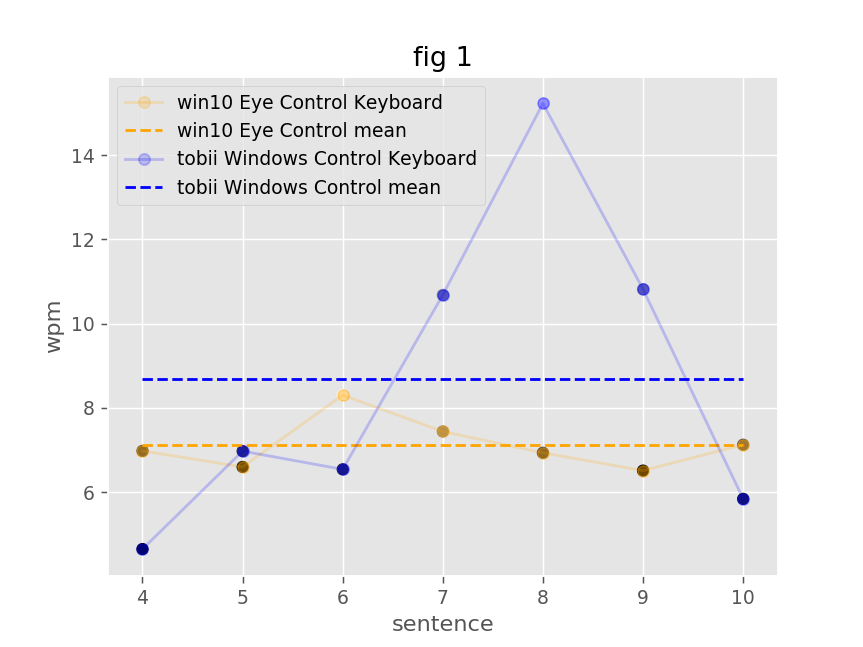

plots


IndexError: list index out of range

In [21]:
%matplotlib notebook	
import csv
from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np


# create Sentence class
class Sentence:
	# class variable shared by all instances
	def __init__(self, subject, task, sentenceNo, testing):
		# instance variable unique to each instance
		self.subject = subject
		self.task = task			# 0: transcribe; 1: free conversation
		self.sentenceNo = sentenceNo
		self.testing = testing
		self.P = ""
		self.T = ""
		self.IS = ""
		self.wpm = 0.0
		self.totErrRate = 0.0
		self.keyboard = 0	# 0: win10 Eye Control; 1: tobii Win Control

def readSentences(argFilename, argSentences):
	with open('RawData/'+argFilename+'.csv') as csvDataFile:
		csvReader = csv.reader(csvDataFile)
		next(csvReader, None)
		next(csvReader, None)
		for row in csvReader:
			# write on keyboard clasification
			if 'Transcribe' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 0, int(row[0]), int(row[1])))
			elif 'FreeConv' in argFilename:
				argSentences.append(Sentence(int(argFilename[0])-1, 1, int(row[0]), int(row[1])))
			# handle exceptions
			# if test subject didn't enter anything and skipped this sentence
			if int(row[2]) != 0:
				sentences[-1].wpm = int(row[4])+int(row[5])*0.1**(len(row[5]))
				sentences[-1].totErrRate = int(row[-14])*0.1**(len(row[-14]))
			else:
				sentences[-1].wpm = 0
				sentences[-1].totErrRate = 1
			if 'winEyeControl' in argFilename:
				sentences[-1].keyboard = 0
			elif 'tobiiWinControl' in argFilename:
				sentences[-1].keyboard = 1

def onChange_typePerf(b):
	if b['type'] == 'change' and b['name'] == 'value':
		print(contrTypePerf.value)

def onChange_task(change):
	if change['type'] == 'change' and change['name'] == 'value':
		plots()

def onChange_subject(change):
	if change['type'] == 'change' and change['name'] == 'value':
		plots()

def delOutliers(argSentenceSet):
	print('did not filter')

# read from UI controls, prepare for plotting
def plots():
	print('plots')
	# read subject selection from UI control
	if contrTask.value == 'Transcribe':
		argTask = 0
	elif contrTask.value == 'Free Conversation':
		argTask = 1
	if contrSubject.value != 'All':
		argSubject = int(contrSubject.value[1])-1
		if contrTypePerf.value == 'Speed (wpm)':
			sentenceKeybdA = [item for item in sentences if item.subject == argSubject and item.task == argTask and item.keyboard == 0 and item.testing == 1]
			sentenceKeybdB = [item for item in sentences if item.subject == argSubject and item.task == argTask and item.keyboard == 1 and item.testing == 1]			
			# delOutliers(sentenceKeybdA)		
			plotSentences(sentenceKeybdA, sentenceKeybdB, 1, 1)	
		elif contrTypePerf.value == 'Accuracy (totErrRate)':
			print('´totErrRate')
	else:
		argSubject = 'All'
		sentencesKeybdA = [item for item in sentences if item.task == argTask and item.keyboard == 0 and item.testing == 1]
		sentencesKeybdB = [item for item in sentences if item.task == argTask and item.keyboard == 1 and item.testing == 1]
		plotSentences(sentencesKeybdA, sentencesKeybdB, 3, 3)

# plot TypePerf of 2 keyboards against sentences, with variable variance visualization,
def plotSentences(argSentenceSet0, argSentenceSet1, argCount0, argCount1):
	# print('plotSentences')
	sentenceKeybdA, sentenceKeybdB = ([] for i in range(2))
	counter = 0
	counterTrim = [[0],[0]]
	subject = argSentenceSet0[0].subject
	# read sentences for a keyboard within a task
	for item in argSentenceSet0:
		if argSentenceSet0[counter].subject != subject:
			counterTrim[0].append(counter)
			subject = argSentenceSet0[counter].subject
		counter += 1
	counterTrim[0].append(len(argSentenceSet0))
	for item in counterTrim[0]:
		if item != 0:
			sentenceKeybdA.append(argSentenceSet0[itemTemp:item])
		itemTemp = item
	counter = 0
	for item in argSentenceSet1:
		if argSentenceSet1[counter].subject != subject:
			counterTrim[1].append(counter)
			subject = argSentenceSet1[counter].subject
		counter += 1
	counterTrim[1].append(len(argSentenceSet1))
	for item in counterTrim[1]:
		if item != 0:
			sentenceKeybdB.append(argSentenceSet1[itemTemp:item])
		itemTemp = item

	# handle exceptions when wpm = 0, replace it with gradient
	x_A, y_A, z_A, yMean_A, x_B, y_B, z_B, yMean_B = ([] for i in range(8))
	for itemI in sentenceKeybdA:
		xTemp, yTemp, zTemp = ([] for i in range(3))
		for itemJ in itemI:
			xTemp.append(itemJ.sentenceNo)
			yTemp.append(itemJ.wpm)
			zTemp.append(itemJ.totErrRate)
		x_A.append(xTemp)
		y_A.append(yTemp)
		z_A.append(zTemp)
	for itemI in sentenceKeybdB:
		xTemp, yTemp, zTemp = ([] for i in range(3))
		for itemJ in itemI:
			xTemp.append(itemJ.sentenceNo)
			yTemp.append(itemJ.wpm)
			zTemp.append(itemJ.totErrRate)
		x_B.append(xTemp)
		y_B.append(yTemp)
		z_B.append(zTemp)

	# plot average horizontal line
	length = [0, 0]
	for j in range(2):
		for i in range(len(counterTrim[j])-1):
			if len(y_A[i]) > length[j]:
				length[j] = len(y_A[i])

	for i in range(length[0]):
		yMeanBuffer = []
		for j in range(len(counterTrim[0])-1):
			try:
				yMeanBuffer.append(y_A[j][i])
			except IndexError:
				print('do nothing here')
		yMeanValue = np.mean(yMeanBuffer)
		yMean_A.append(yMeanValue)
	for i in range(length[1]):
		yMeanBuffer = []
		for j in range(len(counterTrim[1])-1):
			try:
				yMeanBuffer.append(y_B[j][i])
			except IndexError:
				print('do nothing here')
		yMeanValue = np.mean(yMeanBuffer)
		yMean_B.append(yMeanValue)

	fig, ax = plt.subplots()

	for i in range(len(sentenceKeybdA)):
		plt.scatter(x_A[i], y_A[i], c=y_A[i])
		plt.scatter(x_A[i], y_A[i], color='orange', alpha=0.3)
		plt.scatter(x_B[i], y_B[i], c=y_B[i])
		plt.scatter(x_B[i], y_B[i], color='blue', alpha=0.3)		
		if argCount0 == 1: 
			plt.plot(x_A[i], y_A[i], 'o-', label='win10 Eye Control Keyboard', alpha=0.2, color='orange')
			yMeanValue_A = np.mean(y_A[i])
			plt.plot([min(x_A[i]), max(x_A[i])], [yMeanValue_A, yMeanValue_A], '--', label='win10 Eye Control mean', color='orange')
		else:
			plt.plot(range(4, len(yMean_A)+4), yMean_A, '--', label='win10 Eye Control mean', color='orange')
		if argCount1 == 1:
			plt.plot(x_B[i], y_B[i], 'o-', label='tobii Windows Control Keyboard', alpha=0.2, color='blue')
			yMeanValue_B = np.mean(y_B[i])
			plt.plot([min(x_B[i]), max(x_B[i])], [yMeanValue_B, yMeanValue_B], '--', label='tobii Windows Control mean', color='blue')	
		else:
			plt.plot(range(4, len(yMean_B)+4), yMean_B, '--', label='tobii Windows Control mean', color='blue')
	plt.legend(loc='upper left')
	ax.set(title='fig 1', xlabel='sentence', ylabel='wpm')
	plt.set_cmap('gray')	# high error rate deepen the scatter color
	plt.show()


if __name__ == "__main__":
	# read data from .csv
	sentences = []
	readSentences('1Greta_s1Transcribe_winEyeControl', sentences)
	readSentences('1Greta_s2Transcibe_tobiiWinControl', sentences)
	readSentences('2Carlota_s1Transcribe_winEyeControl', sentences)
	readSentences('2Carlota_s2FreeConv_winEyeControl', sentences)
	readSentences('2Carlota_s3Transcribe_tobiiWinControl', sentences)
	readSentences('2Carlota_s4FreeConv_tobiiWinControl', sentences)
	readSentences('3Barbara_s1Transcribe_tobiiWinControl', sentences)
	readSentences('3Barbara_s2FreeConv_tobiiWinControl', sentences)
	readSentences('3Barbara_s3Transcribe_winEyeControl', sentences)
	readSentences('3Barbara_s4FreeConv_winEyeControl', sentences)

	# UI controls
	contrSubject = widgets.Select(
		options=['All', '#1', '#2', '#3'],
		value='#3',
		description='Test Subject:',
		disabled=False
		)
	contrTask = widgets.Select(
		options=['Transcribe', 'Free Conversation'],
		value='Transcribe',
		description='Task:',
		disabled=False
		)
	contrTypePerf = widgets.ToggleButtons(
		options=['Speed (wpm)', 'Accuracy (totErrRate)'],
		value='Speed (wpm)',
		description='Type performance',
		disabled=False,
		button_style=''
		)
	display(widgets.HBox([contrTypePerf, contrTask, contrSubject]))
	contrTypePerf.observe(onChange_typePerf)
	contrTask.observe(onChange_task)
	contrSubject.observe(onChange_subject)

	flagStart = True
	plots()

In [ ]:
cells = [np.array(a) for a in [[0,1,2,3], [2,3,4]]]
np.matrix(cells)
